# <center>Machine Learning Project</center>

** **
## <center>*02 - Feature Selection*</center>

** **

The members of the `team` are:
- Ana Farinha - 20211514
- Francisco Capontes - 20211692
- Sofia Gomes - 20240848
- Rui Lourenço - 2021639

## <span style="color:salmon"> Table of Contents </span>

<a class="anchor" id="top"></a>


1. [Filter Methods](#1-filter-methods)<br>  
    1.1 [Univariate Variables](#11-univariate-variables)<br>  
    1.2 [Correlation Indices](#12-correlation-indices)<br>    
    1.3 [Chi-Squared](#13-chi-squared)<br><br>     
2. [Wrapper Methods](#2-wrapper-methods)<br>    
    2.1 [Logistic Regression](#21-logistic-regression)<br>    
    2.2 [Support Vector Machine](#22-support-vector-machine)<br><br>      
3. [Embedded Methods](#3-embedded-methods)<br>     
    3.1 [LassoCV](#31-lassocv)<br>  



In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Sklearn packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# embedded methods
from sklearn.linear_model import LassoCV
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')

from utils import *
from utils_feature_selection import *


# No train temos de input:
- Average Weekly Wage
- Age at Injury

- Based on the new Age at Injury calcular o Birth Year

*Input `Birth Year`*

In [2]:
# Import dataset
train_df = pd.read_csv('preprocessed_data/train_data.csv', index_col="Claim Identifier")
#test_df =  pd.read_csv('preprocessed_data/test_data.csv', index_col="Claim Identifier")

In [3]:
train_df.drop(['WCIO Cause of Injury Code','WCIO Nature of Injury Code','WCIO Part Of Body Code'], axis=1, inplace=True)

In [4]:
numerical_features = [
    'Age at Injury','Average Weekly Wage','Birth Year','IME-4 Count',
    'Number of Dependents','Days_to_First_Hearing','Days_to_C2','Days_to_C3',
    'Enc WCIO Cause of Injury Code',
    'Nature_Injury_Code_Hash_0','Nature_Injury_Code_Hash_1','Nature_Injury_Code_Hash_2',
    'Nature_Injury_Code_Hash_3','Nature_Injury_Code_Hash_4','Nature_Injury_Code_Hash_5',
    'Nature_Injury_Code_Hash_6','Nature_Injury_Code_Hash_7','Nature_Injury_Code_Hash_8',
    'Nature_Injury_Code_Hash_9','Nature_Injury_Code_Hash_10','Nature_Injury_Code_Hash_11',
    'Nature_Injury_Code_Hash_12','Nature_Injury_Code_Hash_13','Nature_Injury_Code_Hash_14',
    'Nature_Injury_Code_Hash_15','Nature_Injury_Code_Hash_16','Nature_Injury_Code_Hash_17',
    'Nature_Injury_Code_Hash_18','Nature_Injury_Code_Hash_19',
    'Zip_Code_Hash_0','Zip_Code_Hash_1',
    'Zip_Code_Hash_2','Zip_Code_Hash_3','Zip_Code_Hash_4',
    'Zip_Code_Hash_5','Zip_Code_Hash_6','Zip_Code_Hash_7',
    'Zip_Code_Hash_8','Zip_Code_Hash_9','Zip_Code_Hash_10',
    'Zip_Code_Hash_11','Zip_Code_Hash_12','Zip_Code_Hash_13',
    'Zip_Code_Hash_14','Zip_Code_Hash_15','Zip_Code_Hash_16',
    'Zip_Code_Hash_17','Zip_Code_Hash_18','Zip_Code_Hash_19',
    'Accident_Season_Sin','Accident_Season_Cos'
]
categorical_features = [
    'Enc County of Injury', 'Enc District Name','Enc Industry Code',
    'Medical Fee Region_I','Medical Fee Region_II','Medical Fee Region_III','Medical Fee Region_IV',
    'Known Accident Date','Known Assembly Date','Known C-2 Date','Known C-3 Date',
    'Known First Hearing Date','Known Age at Injury','Known Birth Year','Accident Date_Year',
    'Accident Date_Month','Accident Date_Day','Accident Date_DayOfWeek','Assembly Date_Year',
    'Assembly Date_Month','Assembly Date_Day','Assembly Date_DayOfWeek',
    'C-2 Date_Year','C-2 Date_Month','C-2 Date_Day','C-2 Date_DayOfWeek',
    'C-3 Date_Year','C-3 Date_Month','C-3 Date_Day', 'C-3 Date_DayOfWeek',
    'First Hearing Date_Year','First Hearing Date_Month','First Hearing Date_Day','First Hearing Date_DayOfWeek',
    'Holiday_Accident','Weekend_Accident', 'Risk_Level','Gender_F','Gender_M',
    # 'Claim Injury Type Encoded'
]

In [5]:
X = train_df.drop(["Claim Injury Type Encoded"], axis = 1)
y = train_df["Claim Injury Type Encoded"]

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.25, stratify = y, shuffle = True)

# Input Age at Injury, Birth Year and Average Weekly Wage

In [7]:
#X_train_BY = X_train["Birth Year"]
#X_val_BY = X_val["Birth Year"]

In [8]:
#X_train_AD = X_train["Accident Date"]
#X_val_AD = X_val["Accident Date"]

#X_train.drop("Accident Date",axis=1,inplace=True)
#X_val.drop("Accident Date",axis=1,inplace=True)

In [9]:
#imputer = KNNImputer(n_neighbors=3)
#X_train = imputer.fit_transform(X_train)
#X_val = imputer.transform(X_train)

In [10]:
to_impute = ["Age at Injury","Average Weekly Wage"]
imputation_value  = X_train[to_impute].median()
for col in to_impute:
        X_train[col].fillna(imputation_value[col], inplace=True)
        X_val[col].fillna(imputation_value[col], inplace=True)

In [11]:
#X_train["Birth Year"] = X_train_BY
#X_val["Birth Year"] = X_val_BY

In [12]:
# Ensure 'Accident Date' is in datetime format
X_train['Accident Date'] = pd.to_datetime(X_train['Accident Date'], errors='coerce')
X_val['Accident Date'] = pd.to_datetime(X_val['Accident Date'], errors='coerce')

# Now apply your logic
condition = X_train['Birth Year'].isna() & X_train['Age at Injury'].notna() & X_train['Accident Date'].notna()
X_train.loc[condition, 'Birth Year'] = X_train.loc[condition, 'Accident Date'].dt.year - X_train.loc[condition, 'Age at Injury']

# Filter the rows where 'Birth Year' is NaN, but 'Age at Injury' and 'Accident Date' are not NaN
condition = X_val['Birth Year'].isna() & X_val['Age at Injury'].notna() & X_val['Accident Date'].notna()
# Replace missing 'Birth Year' with the difference between 'Accident Date' year and 'Age at Injury'
X_val.loc[condition, 'Birth Year'] = X_val.loc[condition, 'Accident Date'].dt.year - X_val.loc[condition, 'Age at Injury']

In [13]:
X_train.drop('Accident Date',axis=1,inplace=True)
X_val.drop('Accident Date',axis=1,inplace=True)

# Creating New Features

*Average Weekly Wage*

Relative Wage Compared to Median Wage:<br>
Calculate whether the injured worker’s wage is above or below the median wage for the dataset, it's potentially reflecting job type or socioeconomic factors.

In [14]:
median_wage = X_train['Average Weekly Wage'].median()
X_train['Relative_Wage'] = np.where(X_train['Average Weekly Wage'] > median_wage, 1,0) #('Above Median', 'Below Median')
X_val['Relative_Wage'] = np.where(X_val['Average Weekly Wage'] > median_wage, 1,0) #('Above Median', 'Below Median')

*Financial Impact*

In [15]:
financial_impact(X_train)
financial_impact(X_train)

__Binning:__ Group ages into categories like "young" or "senior" if such categories might capture different risk profiles.<br>

In [16]:
age_bins = [0, 25, 40, 55, 70, 100]
age_labels = [0,1,2,3,4] #['Young', 'Mid-Age', 'Experienced', 'Senior', 'Elderly']
X_train['Age_Group'] = pd.cut(X_train['Age at Injury'], bins=age_bins, labels=age_labels)
X_val['Age_Group'] = pd.cut(X_val['Age at Injury'], bins=age_bins, labels=age_labels)

# Scaling

In [17]:
mm = StandardScaler()
X_train[numerical_features] = mm.fit_transform(X_train[numerical_features])
X_val[numerical_features] = mm.transform(X_val[numerical_features])

# Feature Selection

In [18]:
n_features = len(X_train.columns)

*Univariate variables*

In [19]:
X_train[numerical_features].var().sort_values()

Nature_Injury_Code_Hash_18       0.000000
Nature_Injury_Code_Hash_16       1.000002
Nature_Injury_Code_Hash_6        1.000002
Nature_Injury_Code_Hash_10       1.000002
Zip_Code_Hash_7                  1.000002
Days_to_C2                       1.000002
Zip_Code_Hash_6                  1.000002
Enc WCIO Cause of Injury Code    1.000002
Nature_Injury_Code_Hash_11       1.000002
Birth Year                       1.000002
Accident_Season_Sin              1.000002
Nature_Injury_Code_Hash_5        1.000002
Zip_Code_Hash_5                  1.000002
Zip_Code_Hash_8                  1.000002
Zip_Code_Hash_1                  1.000002
Nature_Injury_Code_Hash_19       1.000002
Zip_Code_Hash_15                 1.000002
Nature_Injury_Code_Hash_14       1.000002
Zip_Code_Hash_10                 1.000002
Accident_Season_Cos              1.000002
Days_to_C3                       1.000002
Number of Dependents             1.000002
Zip_Code_Hash_18                 1.000002
Zip_Code_Hash_17                 1

In [20]:
X_train.drop("Nature_Injury_Code_Hash_18", axis=1,  inplace=True)
X_val.drop("Nature_Injury_Code_Hash_18", axis=1,  inplace=True)
numerical_features.remove("Nature_Injury_Code_Hash_18")

*Corr Matrix*

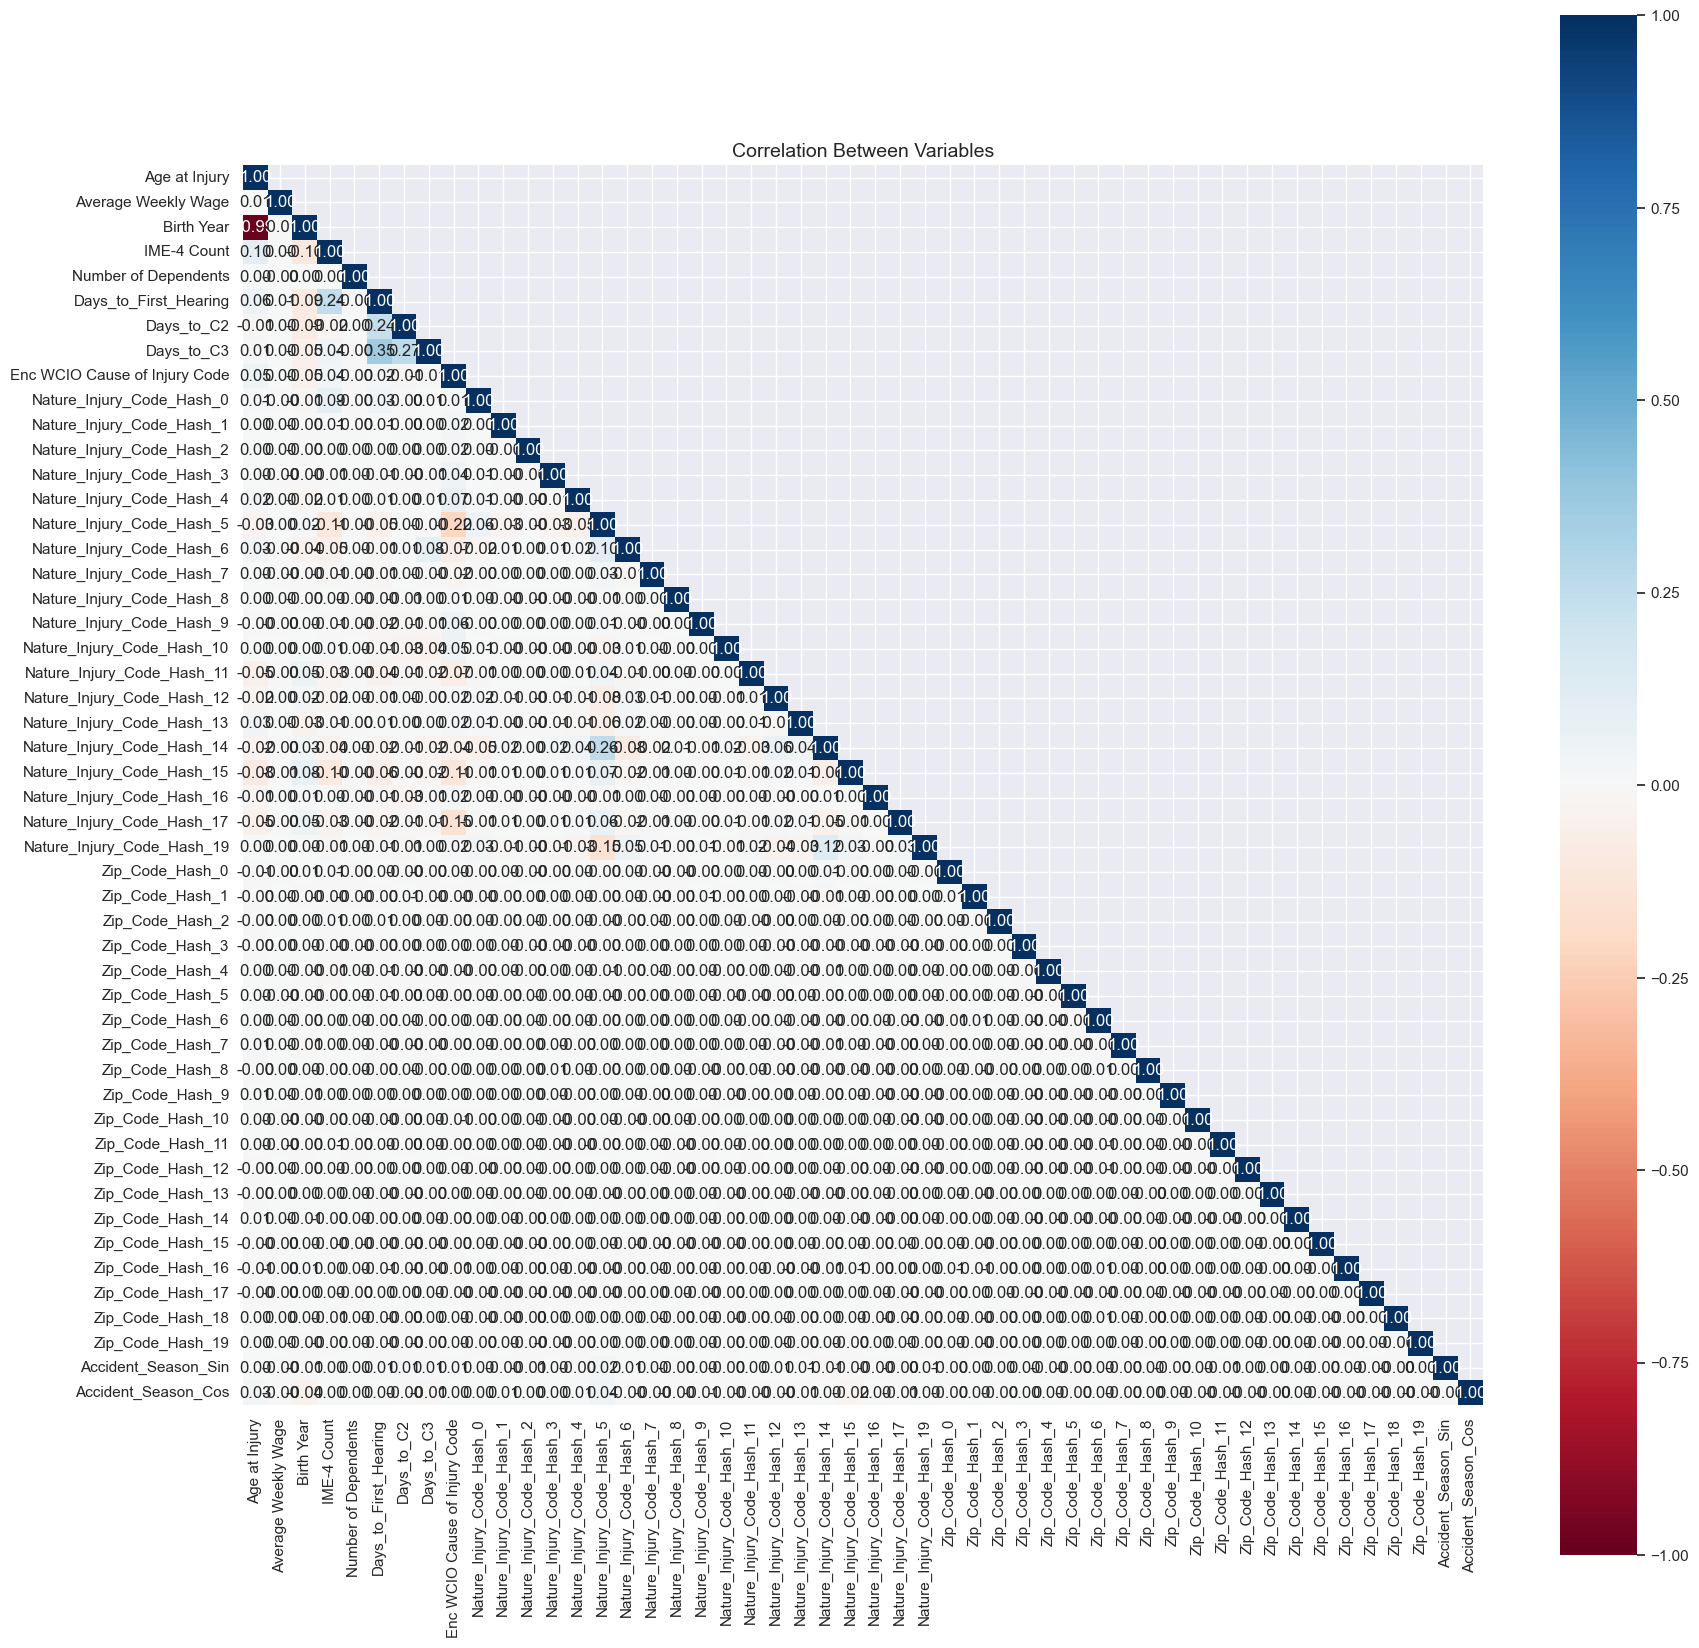

In [21]:
# initial correlation matrix with the respective values
corr_matrix = X_train[numerical_features].corr()

mask = np.tri(*corr_matrix.shape, k=0, dtype=bool)
# Keeps values where mask is True
corr_matrix = corr_matrix.where(mask)

# defines the figure size
fig, ax = plt.subplots(figsize=(20, 20))
# heatmap of the initial correlation matrix
l = sns.heatmap(corr_matrix, square=True, annot=True, fmt=".2f", vmax=1, vmin=-1, cmap='RdBu', ax=ax)
plt.title('Correlation Between Variables', size=14)
plt.show()

*XGBoosted RFE*

In [22]:
XGB = XGBClassifier(XGBClassifier(objective='binary:logistic',  
                                eval_metric='mlogloss',         
                                use_label_encoder=False
                                ))

In [23]:
best_XGB = feature_selection_RFE(X_train,y_train,n_features,model=XGB)

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x00000204E39CE030>>
Traceback (most recent call last):
  File "C:\Users\ruipb\Desktop\Masters\Projects\Machine_Learning_NOVAIMS\env\Lib\site-packages\xgboost\core.py", line 582, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 


XGBoostError: [10:54:54] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\data\iterative_dmatrix.cc:232: Check failed: accumulated_rows == Info().num_row_ (861036 vs. 430518) : 

In [ ]:
best_XGB

*CatBoosted RFE*

In [ ]:
CB = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, cat_features=[])

In [ ]:
best_CB = feature_selection_RFE(X_train,y_train,n_features,model=CB)

In [ ]:
best_CB

*Lasso*

In [ ]:
feature_selection_Lasso(X_train_temp[numerical_features],y_train_temp)

*Chi-squared test*

In [ ]:
for col in categorical_features+binary_features:
    TestIndependence(X_train[col],y_train,col,alpha=0.05)

<hr>

### Numerical Data

| Predictor | Spearman | RFE XGB| RFE DT | Lasso | What to do? (One possible way to "solve") |
| --- | --- | --- | --- |--- |---|
| Age at Injury | Keep? | Discard | Discard |Discard | Discard |
| IME-4 Count | Keep | Keep | Keep |Keep| Include in the model |
| WCIO Cause of Injury Code | Keep| Keep | Discard | Discard | Try with and without |
| WCIO Nature of Injury Code | Keep | Keep | Keep | Discard | Include in the model |
| WCIO Part Of Body Code | Keep | Keep | Discard | Discard | Try with and without |
| Number of Dependents | Keep | Discard | Discard | Discard | Discard |
| Years Past Accident | Keep | Keep | Discard | Keep | Include in the model |
| Assembly Years past Accident | Discard |Keep |Discart | Keep |  Discard | # Years Past Accident
| Industry Code | Keep |Keep |Discard | Keep |   Include in the model |
| Birth Year | Keep? |Keep |Discard | Keep |  Try with and without |
| Average Weekly Wage | Keep |Keep |Keep | Keep |  Include in the model |

<hr>

### Categorical Data

| Predictor | Chi-Square |
| --- | --- |
| Carrier Name | Keep |  
| Carrier Type | Keep |
| County of Injury| Keep|
| District Name| Keep|
| Gender | Keep |
| Medical Fee Region | Keep |
| Attorney/Representative | Keep |
| COVID-19 Indicator | Keep |
| First Hearing Date Occurred | Keep |
| C-2 Date Occurred | Keep |
| C-3 Date Occurred| Keep |
| Birth Year Occurred | Keep |
| Age at Injury Occurred | Keep |
| Accident Date Occurred | KEEP |

<hr>

In [ ]:
class_mapping = {
    0:'1. CANCELLED', 
    1:'2. NON-COMP',
    2:'3. MED ONLY', 
    3:'4. TEMPORARY',
    4:'5. PPD SCH LOSS', 
    5:'6. PPD NSL', 
    6:'7. PTD', 
    7:'8. DEATH'
}
test_encoder = LabelEncoder()
test_encoder.classes_ = np.array(list(class_mapping.values()))